# Collaboration and Competition

---

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.7 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
from workspace_utils import active_session
import random
import torch
import numpy as np
import datetime
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from ddpg_agent import Agent, ReplayBuffer

In [3]:
env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### MADDPG

In [6]:
env_info = env.reset(train_mode=True)[brain_name]
n_agents = len(env_info.agents)
seed = 5
# initialize agents
agent = Agent(state_size=state_size, 
                action_size=action_size, 
                random_seed=seed,
                num_agents=n_agents)

Start Time: 2020-09-10 18:15:09.565942
Episode 100	Average Score: -0.00	Score: -0.00
Episode 200	Average Score: -0.00	Score: -0.00
Episode 300	Average Score: 0.02	Score: 0.0500
Episode 400	Average Score: 0.02	Score: -0.00
Episode 500	Average Score: 0.02	Score: -0.00
Episode 600	Average Score: 0.04	Score: -0.00
Episode 700	Average Score: 0.04	Score: -0.00
Episode 800	Average Score: 0.03	Score: 0.050
Episode 900	Average Score: 0.07	Score: 0.05
Episode 1000	Average Score: 0.05	Score: -0.00
Episode 1100	Average Score: 0.10	Score: 0.050
Episode 1200	Average Score: 0.47	Score: 2.600
Episode 1205	Average Score: 0.52	Score: 2.600

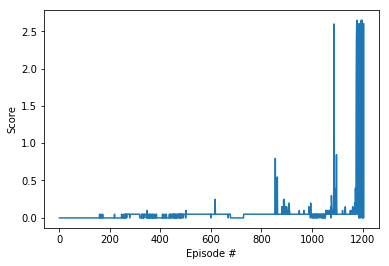

End Time: 2020-09-10 18:23:07.803122


In [12]:
with active_session():
    def ddpg(n_episodes=1500, max_t=1000):
        scores_deque = deque(maxlen=100)
        scores_mean = []
        max_score = -np.Inf
        UPDATE_FREQ = 2
        for i_episode in range(1, n_episodes+1):
            env_info = env.reset(train_mode=True)[brain_name]  
            states = env_info.vector_observations                  # get the current state (for each agent)
            scores = np.zeros(num_agents) 
            agent.reset()
            update = False
            for t in range(max_t):
                actions = agent.act(states)
                env_info = env.step(actions)[brain_name]           # send all actions to tne environment
                next_states = env_info.vector_observations         # get next state (for each agent)
                rewards = env_info.rewards                         # get reward (for each agent)
                dones = env_info.local_done                        # see if episode finished
                scores += env_info.rewards                         # update the score (for each agent) 
                if t % UPDATE_FREQ == 0:
                    update = True
                agent.step(states, actions, rewards, next_states, dones, update)
                update = False
                states = next_states 
                if np.any(dones):
                    break 
            scores_deque.append(np.mean(scores))
            scores_mean.append(np.mean(scores))
            print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, 
                                                                              np.mean(scores_deque), 
                                                                              np.mean(scores)), end="")
            if i_episode % 100 == 0:
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
                torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))   
            if np.mean(scores_deque) > 0.5:
                break
        return scores_mean
    print('Start Time: {}'.format(str(datetime.datetime.now())))
    scores_mean = ddpg()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores_mean)+1), scores_mean)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()
    print('End Time: {}'.format(str(datetime.datetime.now())))

When finished, you can close the environment.

In [10]:
env.close()